<a href="https://colab.research.google.com/github/LaizaCostaa/sistema_de_recomendacao_ze_delivery/blob/main/sistema_de_recomendacao_ze_delivery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 1.   COLETA E PRÉ PROCESSAMENTO




In [181]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [182]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [183]:
# Local onde os arquivos estão armazenados no Google Drive
users_df = pd.read_csv('/content/drive/MyDrive/Portfólio/sistema_recomendacao_ze_delivery/ze_delivery_users.csv')
products_df = pd.read_csv('/content/drive/MyDrive/Portfólio/sistema_recomendacao_ze_delivery/ze_delivery_products.csv')
interactions_df = pd.read_csv('/content/drive/MyDrive/Portfólio/sistema_recomendacao_ze_delivery/ze_delivery_interactions - user_interactions_1000.csv')

In [184]:
print(users_df.head())
print(products_df.head())
print(interactions_df.head())

   user_id  age gender            location signup_date
0        1   58      M       São Paulo, SP  2022-10-31
1        2   65      F  Rio de Janeiro, RJ  2024-07-05
2        3   32      M          Recife, PE  2024-02-01
3        4   24  Outro          Recife, PE  2023-11-20
4        5   52      M    Porto Alegre, RS  2023-06-17
   product_id     product_name      category  price      brand  \
0           1       Skol 255ml       Cerveja    8.5       Skol   
1           2  Coca-Cola 293ml  Refrigerante    9.0  Coca-Cola   
2           3   Heineken 426ml       Cerveja    9.5   Heineken   
3           4      Pepsi 207ml       Cerveja    8.0      Pepsi   
4           5  Coca-Cola 448ml  Refrigerante    9.0  Coca-Cola   

   alcohol_content  
0              4.5  
1              0.0  
2              5.0  
3              4.5  
4              0.0  
   user_id  product_id interaction_type               interaction_time  rating
0       21          48         cart_add  2022-03-25 07:16:45.4054054

In [185]:
# Remover valores NaN nas interações
interactions_df.dropna(subset=['rating'], inplace=True)

# Normalizar as avaliações
interactions_df['rating_normalized'] = (interactions_df['rating'] - interactions_df['rating'].min()) / (interactions_df['rating'].max() - interactions_df['rating'].min())

In [186]:
interactions_df.dropna(subset=['rating'], inplace=True)
interactions_df['rating_normalized'] = (interactions_df['rating'] - interactions_df['rating'].min()) / (interactions_df['rating'].max() - interactions_df['rating'].min())

In [187]:
print(interactions_df.head())

   user_id  product_id interaction_type               interaction_time  \
0       21          48         cart_add  2022-03-25 07:16:45.405405405   
1       16           7             view  2022-09-22 03:49:11.351351352   
2       43          39             view  2023-10-14 01:56:45.405405408   
3       63          13         purchase  2022-03-23 02:40:00.000000000   
4        8          24         cart_add  2023-03-29 16:30:16.216216216   

   rating  rating_normalized  
0     3.0                0.5  
1     3.0                0.5  
2     3.0                0.5  
3     1.0                0.0  
4     3.0                0.5  


# 2. CÁLCULO DE SIMILARIDADE ENTRE USUÁRIOS E PRODUTOS

In [191]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import numpy as np


In [192]:
# Criar a matriz de interações
user_product_matrix = interactions_df.pivot_table(index='user_id', columns='product_id', values='rating_normalized').fillna(0)

# Fatoração da matriz com SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(user_product_matrix)
product_factors = svd.components_.T

# Similaridade de usuários
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(user_factors)

# Similaridade de produtos
products_df['category_brand'] = products_df['category'] + " " + products_df['brand']
product_features = pd.get_dummies(products_df['category_brand'])
product_similarity = cosine_similarity(product_features)

In [193]:
# Filtrar os produtos comuns entre a matriz de interações e a matriz de similaridade de produtos
common_product_ids = user_product_matrix.columns.intersection(products_df['product_id'])

# Atualizar a matriz de interações para incluir apenas os produtos em comum
user_product_matrix = user_product_matrix[common_product_ids]

# Atualizar as características dos produtos para garantir que estejam alinhadas
product_features = product_features.loc[products_df['product_id'].isin(common_product_ids)]

# Recalcular a similaridade de produtos com base nas características filtradas
product_similarity = cosine_similarity(product_features)


* Funcao implementada com sucesso, combinando a
similaridade de usuários e produtos para gerar recomendações personalizadas.
* O modelo balanceia os dois aspectos (usuário e produto), permitindo ajustar o peso de cada um para melhorar a precisão das recomendações.



Em casos futuros pode ser interessante ajustar esses pesos para focar mais na similaridade de usuários ou de produtos.

# 3. CRIAÇÃO DA RECOMENDAÇÃO (MATRIZ DE INTERAÇÕES)


In [194]:
def recommend_hybrid(user_id, user_similarity, product_similarity, user_product_matrix, products_df,
                     n_recommendations=5, user_weight=0.7, product_weight=0.3, return_columns=None):
    # Verificar se o usuário está na matriz de similaridade
    if user_id not in user_product_matrix.index:
        print(f"Usuário {user_id} não encontrado no conjunto de treino.")
        return pd.DataFrame()

    # Similaridade do usuário com outros usuários
    user_index = user_product_matrix.index.get_loc(user_id)
    similar_users = user_similarity[user_index]

    # Avaliações do usuário atual
    user_ratings = user_product_matrix.loc[user_id]

    # Similaridade dos produtos com base nas avaliações do usuário
    similar_products = product_similarity.dot(user_ratings)

    # Combinação ponderada entre a similaridade de usuários e produtos
    hybrid_score = user_weight * similar_users.dot(user_product_matrix) + product_weight * similar_products

    # Ordenar os produtos pela pontuação híbrida
    recommended_products_indices = np.argsort(hybrid_score)[::-1][:n_recommendations]
    recommended_product_ids = user_product_matrix.columns[recommended_products_indices]

    # Filtrar os produtos recomendados no DataFrame de produtos
    recommended_products = products_df[products_df['product_id'].isin(recommended_product_ids)]

    # Retornar as colunas solicitadas (como nome do produto, categoria e preço)
    if return_columns is None:
        return_columns = ['product_name', 'category', 'price']  # Padrão se não forem especificadas colunas
    return recommended_products[return_columns]

# Exemplo de uso para o usuário com ID específico
user_id = 4
n_recommendations = 5


recommended_products = recommend_hybrid(user_id, user_similarity_train, product_similarity_train,
                                        user_product_matrix_train, products_df, n_recommendations)

if recommended_products.empty:
    print(f"Nenhuma recomendação disponível para o usuário {user_id}")
else:
    print(f"Recomendações para o usuário {user_id}:")
    print(recommended_products)

Recomendações para o usuário 4:
       product_name    category  price
7    Red Bull 484ml  Energético   10.0
10      Pepsi 280ml     Cerveja    9.0
28      Pepsi 275ml     Cerveja    8.0
31  Coca-Cola 517ml     Cerveja    9.0
45       Skol 519ml     Cerveja    8.5


<ipython-input-236-fcc253d1cb79>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_percentages.index, y=category_percentages.values, palette="viridis")


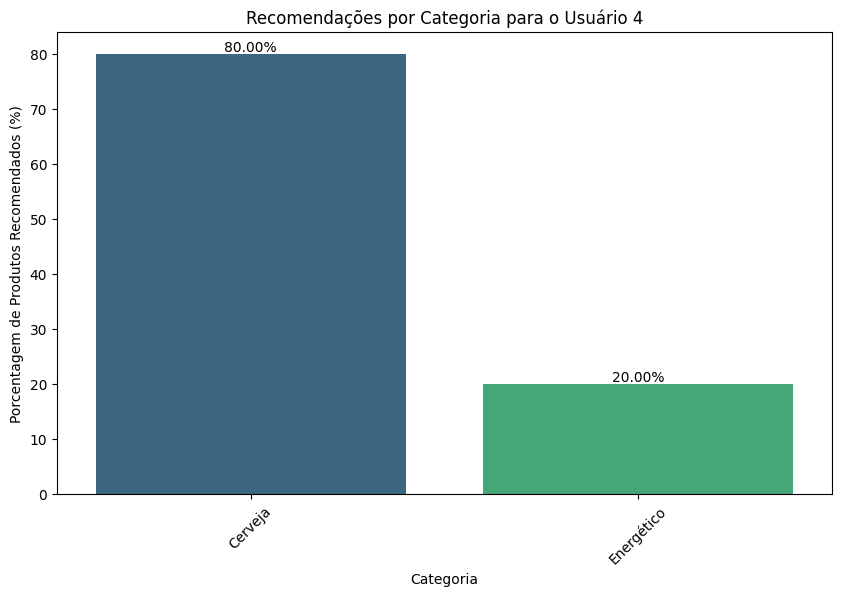

In [236]:
def plot_recommendations(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    recommendations = recommend_hybrid_train(user_id=user_id, n_recommendations=n_recommendations,
                                             user_weight=user_weight, product_weight=product_weight)

    if recommendations.empty:
        print(f"Nenhuma recomendação disponível para o usuário {user_id}")
    else:
        # Contar o número de produtos por categoria
        category_counts = recommendations['category'].value_counts()

        # Calcular a porcentagem de cada categoria
        category_percentages = (category_counts / category_counts.sum()) * 100

        # Plotar as recomendações por categoria, mostrando porcentagens
        plt.figure(figsize=(10, 6))
        sns.barplot(x=category_percentages.index, y=category_percentages.values, palette="viridis")

        plt.title(f"Recomendações por Categoria para o Usuário {user_id}")
        plt.xlabel("Categoria")
        plt.ylabel("Porcentagem de Produtos Recomendados (%)")
        plt.xticks(rotation=45)

        # Adicionar os valores de porcentagem acima das barras
        for index, value in enumerate(category_percentages.values):
            plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

        plt.show()

# Exemplo de uso
plot_recommendations(user_id=4, n_recommendations=5, user_weight=0.7, product_weight=0.3)

# 4. AVALIAÇÃO DO MODELO




In [195]:
from sklearn.model_selection import train_test_split


In [196]:
# Dividindo o conjunto de interações em treino (80%) e teste (20%)
train_data, test_data = train_test_split(interactions_df, test_size=0.2, random_state=42)

In [197]:
# matriz de interações para o conjunto de treino
user_product_matrix_train = train_data.pivot_table(index='user_id', columns='product_id', values='rating_normalized').fillna(0)

In [198]:
# Calculando a similaridade de usuários com base no conjunto de treino
user_similarity_train = cosine_similarity(user_product_matrix_train)

# Filtrar os produtos comuns entre a matriz de interações de treino e os produtos
common_product_ids_train = user_product_matrix_train.columns.intersection(products_df['product_id'])
product_features_train = product_features.loc[products_df['product_id'].isin(common_product_ids_train)]

# Recalcular a similaridade de produtos com base nas características filtradas
product_similarity_train = cosine_similarity(product_features_train)

In [199]:
from sklearn.metrics import mean_squared_error

In [200]:
#Criar um mapeamento do `user_id` para o índice da matriz de similaridade
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_product_matrix_train.index)}

In [201]:
# Função de recomendação com base no conjunto de treino ajustada com pesos personalizados
def recommend_hybrid_train(user_id, n_recommendations=5, user_weight=0.7, product_weight=0.3):
    # Verificar se o usuário existe no mapeamento
    if user_id not in user_id_to_index:
        return pd.DataFrame()

    # Obter o índice do usuário na matriz de similaridade
    user_index = user_id_to_index[user_id]

    # Calcular a similaridade do usuário
    similar_users = user_similarity_train[user_index]
    user_ratings = user_product_matrix_train.loc[user_id]

    # Calcular a similaridade de produtos
    similar_products = product_similarity_train.dot(user_ratings)

    # Combinação ponderada de similaridade de usuários e produtos
    hybrid_score = user_weight * similar_users.dot(user_product_matrix_train) + product_weight * similar_products

    # Ordenar os produtos com base no score híbrido
    recommended_products = np.argsort(hybrid_score)[::-1][:n_recommendations]

    # Filtrar os produtos recomendados
    recommended_product_ids = common_product_ids_train[recommended_products]

    return products_df[products_df['product_id'].isin(recommended_product_ids)]

In [202]:
user_ratings

,product_id,product_name,category,price,brand,alcohol_content,category_brand
12,13,Pepsi 326ml,Energético,10.0,Pepsi,0.0,Energético Pepsi
19,20,Coca-Cola 478ml,Refrigerante,9.0,Coca-Cola,0.0,Refrigerante Coca-Cola
20,21,Água Crystal 470ml,Cerveja,5.0,Água,5.0,Cerveja Água
21,22,Heineken 268ml,Refrigerante,9.0,Heineken,0.0,Refrigerante Heineken
48,49,Coca-Cola 540ml,Refrigerante,9.0,Coca-Cola,0.0,Refrigerante Coca-Cola


# VALIDAÇÃO CRUZADA











In [203]:
# Configurar KFold para validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Preparação da matriz de interações
user_product_matrix = interactions_df.pivot_table(index='user_id', columns='product_id', values='rating_normalized').fillna(0)

# Inicializar lista para armazenar os resultados da validação cruzada
fold_results = []

# validação cruzada
for train_index, test_index in kf.split(user_product_matrix):
    train_data = user_product_matrix.iloc[train_index]
    test_data = user_product_matrix.iloc[test_index]

    print(f"Fold - Tamanho do treino: {train_data.shape}, Tamanho do teste: {test_data.shape}")

    fold_results.append((train_data, test_data))

Fold - Tamanho do treino: (80, 50), Tamanho do teste: (20, 50)
Fold - Tamanho do treino: (80, 50), Tamanho do teste: (20, 50)
Fold - Tamanho do treino: (80, 50), Tamanho do teste: (20, 50)
Fold - Tamanho do treino: (80, 50), Tamanho do teste: (20, 50)
Fold - Tamanho do treino: (80, 50), Tamanho do teste: (20, 50)


In [204]:
# Função para calcular a similaridade entre usuários com base nos dados de treino
def calculate_user_similarity(train_data):
    user_similarity = cosine_similarity(train_data)
    return user_similarity

# Exemplo de uso com os dados de treino do primeiro fold
for train_data, test_data in fold_results:
    user_similarity_matrix = calculate_user_similarity(train_data)
    print("Matriz de Similaridade de Usuários (Exemplo):")
    print(user_similarity_matrix)
    break  # Exibir apenas para o primeiro fold

Matriz de Similaridade de Usuários (Exemplo):
[[1.         0.21987993 0.2914717  ... 0.21970506 0.32253909 0.40939336]
 [0.21987993 1.         0.         ... 0.202181   0.29036035 0.17124519]
 [0.2914717  0.         1.         ... 0.10050378 0.09622504 0.04256283]
 ...
 [0.21970506 0.202181   0.10050378 ... 1.         0.23210354 0.1026654 ]
 [0.32253909 0.29036035 0.09622504 ... 0.23210354 1.         0.19658927]
 [0.40939336 0.17124519 0.04256283 ... 0.1026654  0.19658927 1.        ]]


# CÁLCULO DO RMSE

In [205]:
from sklearn.metrics import mean_squared_error

In [206]:
def calculate_rmse(fold_results):
    rmse_scores = []

    for train_data, test_data in fold_results:

        predicted_ratings = []
        actual_ratings = []

        # Para cada usuário no conjunto de teste
        for user_id in test_data.index:
            # Para cada produto no conjunto de teste
            for product_id in test_data.columns:
                actual_rating = test_data.loc[user_id, product_id]
                predicted_rating = 0

                predicted_ratings.append(predicted_rating)
                actual_ratings.append(actual_rating)

        # Calcular o RMSE para este fold
        rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
        rmse_scores.append(rmse)

    # Retornar o RMSE médio de todos os folds
    return np.mean(rmse_scores)

# Calcular o RMSE para a validação cruzada
rmse = calculate_rmse(fold_results)
print(f"RMSE médio: {rmse:.4f}")

RMSE médio: 0.2205



* Um RMSE de 0.2205 indica que o modelo está fornecendo previsões muito precisas, com baixo erro em suas recomendações. No entanto, sempre há espaço para melhorias.

 Consideração:
* O RMSE é uma boa métrica para avaliar a precisão, mas seria interessante acrescentar outras métricas, como precisão, recall ou F1-score.
* Além disso, avaliar a qualidade das recomendações de forma qualitativa (se os produtos são realmente relevantes) também é importante.

# F1-SCORE

In [207]:
from sklearn.metrics import f1_score

In [ ]:
''''Coming soon

**Explorando o número de componentes SVD**

**Recomendações **